In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load data
df = pd.read_csv('/content/labelled_data.csv')

In [6]:
# Encode target labels
df = df[df['majority_vote'].isin(['positive', 'negative'])]  # Filter only binary labels
df['ground_truth'] = pd.Categorical(df['majority_vote']).codes
y = df['ground_truth']

In [7]:
def plot_class_distribution(y, title='Class Distribution'):
    """Plot the distribution of classes in the target variable."""
    plt.figure(figsize=(10, 5))
    sns.countplot(x=y)
    plt.title(title)
    plt.show()

In [8]:
def create_resampling_pipeline(smote_ratio=0.5, undersample_ratio=0.7, random_state=42):
    """Create a resampling pipeline with SMOTE and RandomUnderSampler."""
    return Pipeline([
        ('smote', SMOTE(sampling_strategy=smote_ratio, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=random_state))
    ])

In [34]:
def prepare_training_data(X, y, test_size=0.2, random_state=42):
    """Prepare and resample training data."""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # Convert to dense format if using sparse matrices
    if hasattr(X_train, 'toarray'):
        X_train = X_train.toarray()
        X_test = X_test.toarray()

    # Apply resampling
    resampling = create_resampling_pipeline()
    X_train_resampled, y_train_resampled = resampling.fit_resample(X_train, y_train)

    return X_train_resampled, X_test, y_train_resampled, y_test

In [35]:
def train_evaluate_svm(X_train, X_test, y_train, y_test):
    """Train and evaluate SVM model."""
    # Initialize SVM with class weight balancing
    svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42, probability=True)

    # Train the model
    svm_model.fit(X_train, y_train)

    # Make predictions
    y_pred = svm_model.predict(X_test)
    y_pred_proba = svm_model.decision_function(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return svm_model

In [46]:
def train_and_evaluate(X, y):
    """Main function to train and evaluate SVM."""
    # Plot initial class distribution
    plot_class_distribution(y, title='Initial Class Distribution')

    # Prepare data
    X_train_resampled, X_test, y_train_resampled, y_test = prepare_training_data(X, y)

    # Plot resampled class distribution
    plot_class_distribution(y_train_resampled, title='Class Distribution After Resampling')

    # Train and evaluate SVM model
    svm_model = train_evaluate_svm(X_train_resampled, X_test, y_train_resampled, y_test)

    # Return the trained model
    return svm_model

In [37]:
# Count Vectors
count_vectorizer = CountVectorizer(max_features=3000, min_df=5, max_df=0.8)
X_count = count_vectorizer.fit_transform(df['spacy_tokens'])  # Transform text into sparse matrix

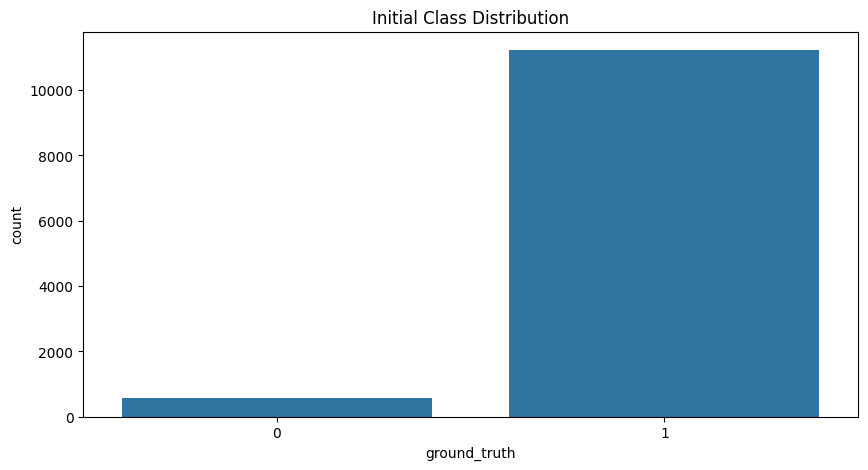

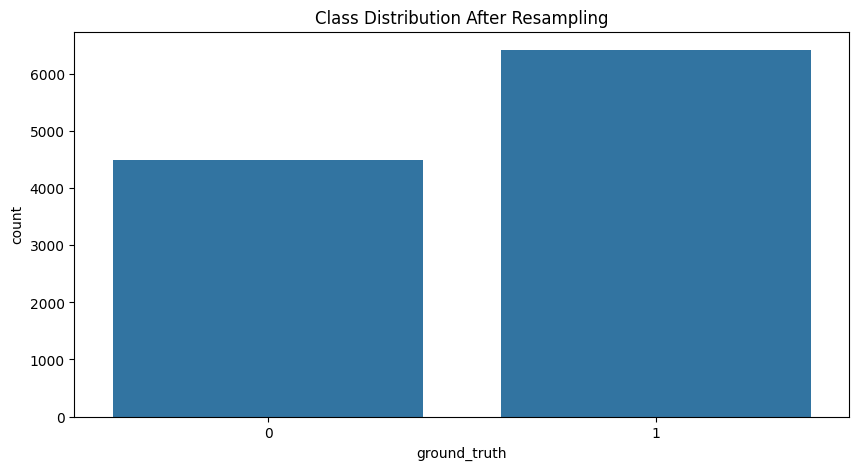


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       113
           1       0.99      0.98      0.98      2246

    accuracy                           0.97      2359
   macro avg       0.82      0.85      0.83      2359
weighted avg       0.97      0.97      0.97      2359



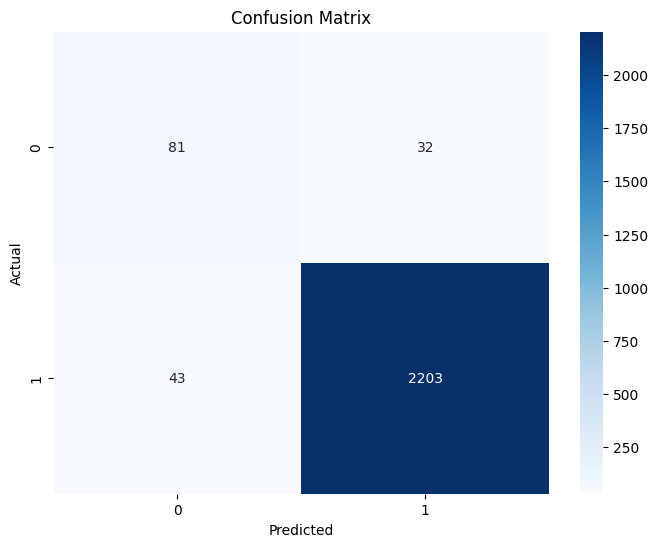

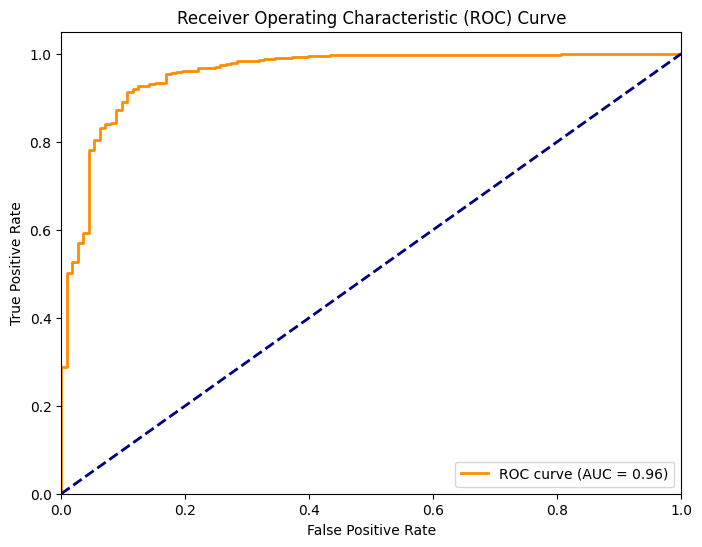

In [38]:
model_count = train_and_evaluate(
    X_count,
    y
)

In [40]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000, min_df=5, max_df=0.8)
X_tfidf = tfidf_vectorizer.fit_transform(df['review_text'])

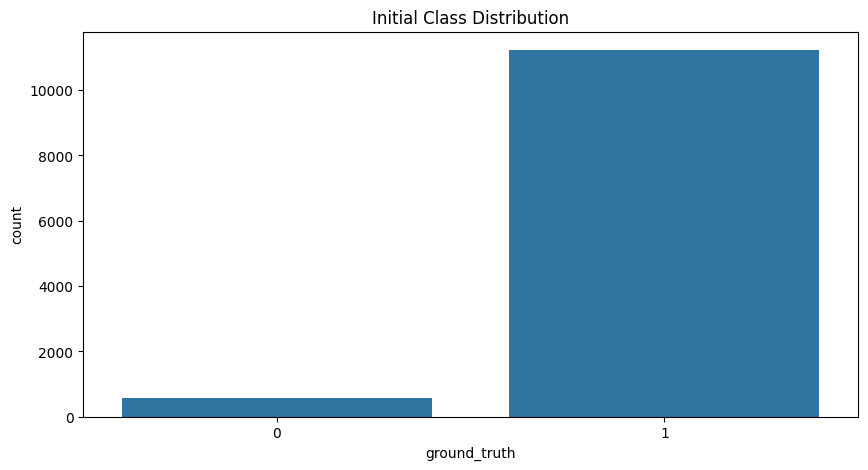

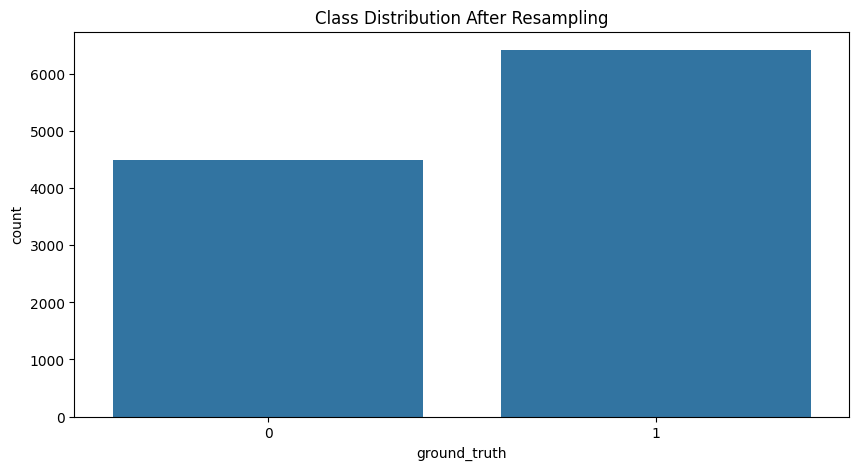


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       113
           1       0.99      0.98      0.99      2246

    accuracy                           0.98      2359
   macro avg       0.86      0.89      0.87      2359
weighted avg       0.98      0.98      0.98      2359



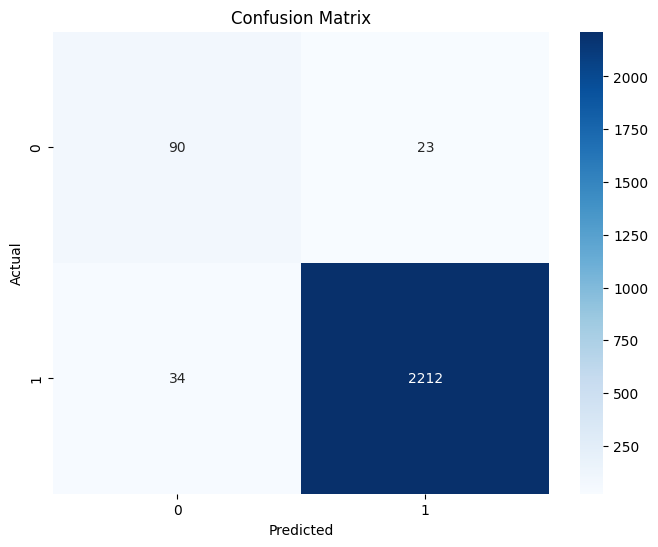

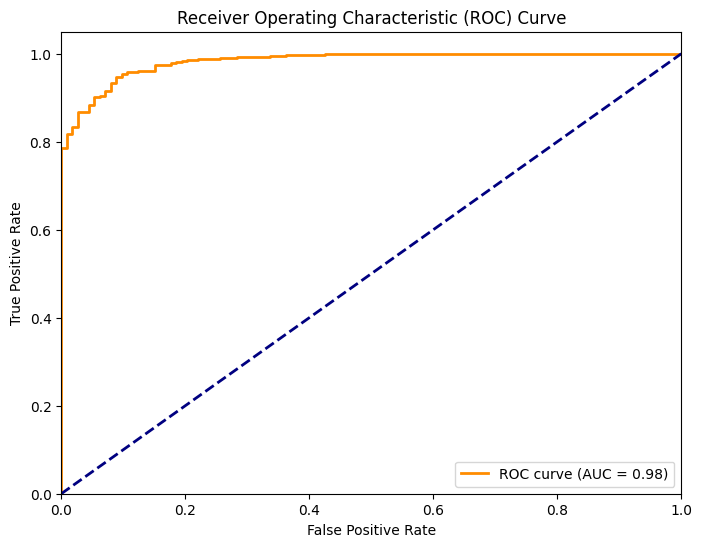

In [41]:
model_tfidf = train_and_evaluate(
    X_tfidf,
    y
)

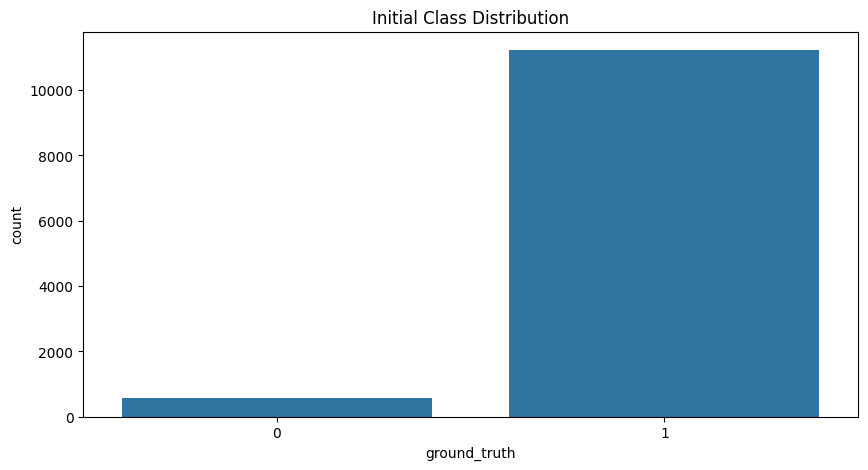

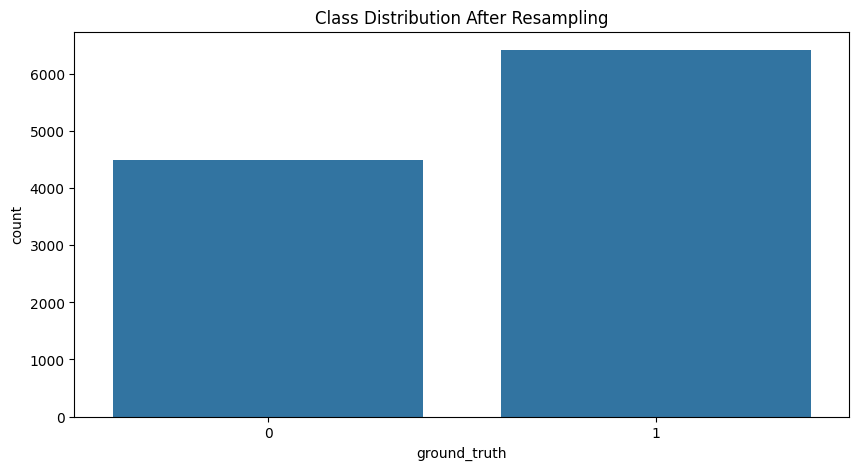


Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.54      0.09       113
           1       0.95      0.45      0.61      2246

    accuracy                           0.46      2359
   macro avg       0.50      0.50      0.35      2359
weighted avg       0.91      0.46      0.59      2359



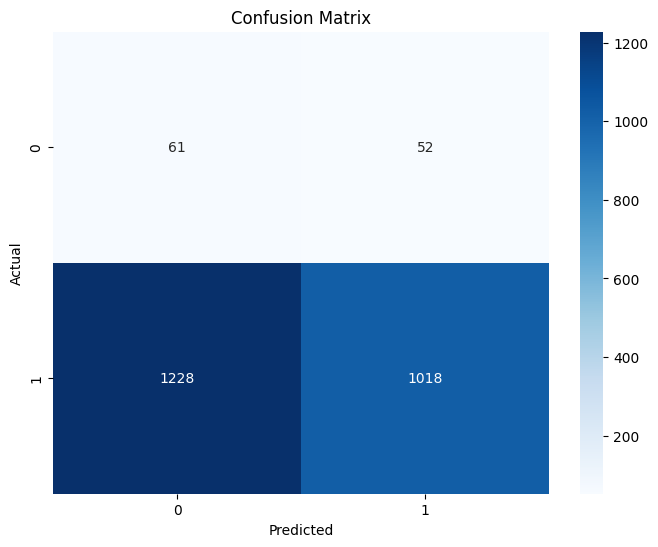

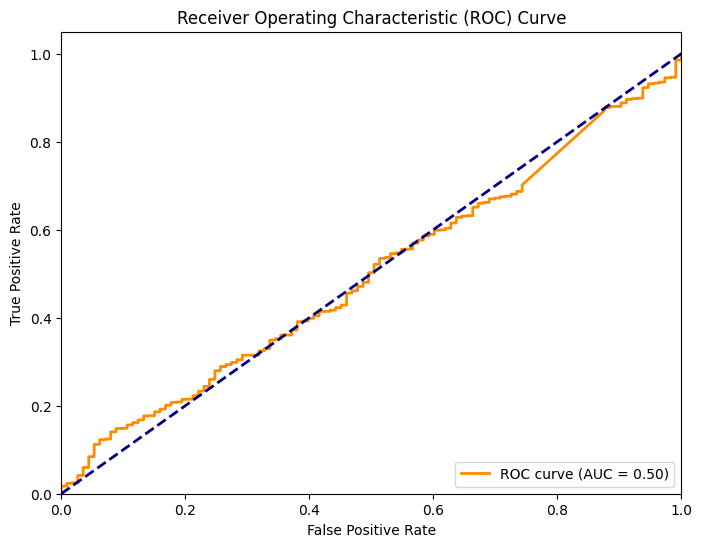

In [48]:
# Glove Dense Vectors
X_glove = np.load('/content/glove_embedding_matrix.npy')
# Align GloVe embeddings with labels if necessary
if len(X_glove) > len(y):
    X_glove = X_glove[:len(y)]

# Train and evaluate SVM with GloVe embeddings
svm_model_glove = train_and_evaluate(X_glove, y)


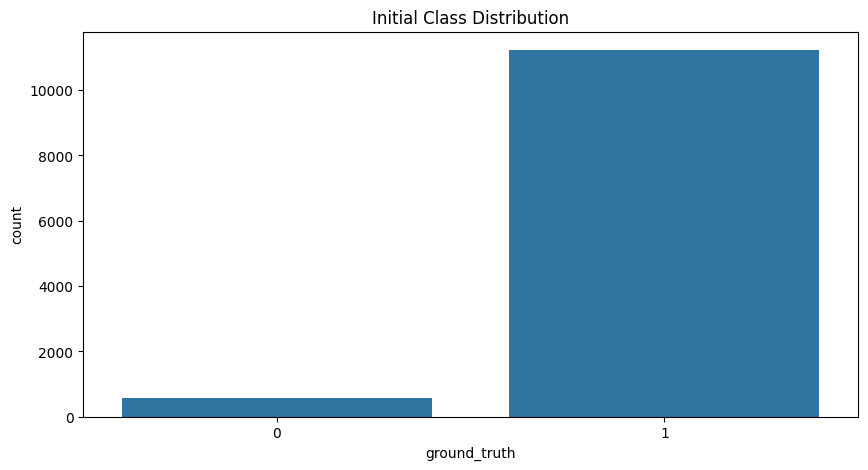

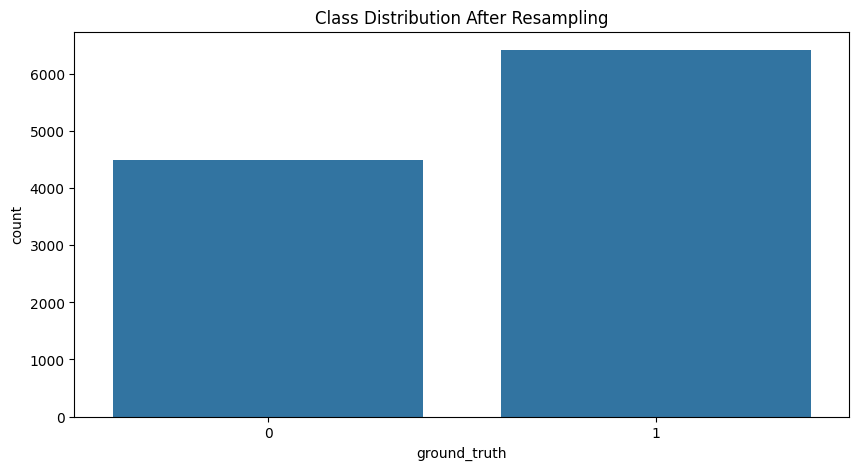


Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.59      0.11       113
           1       0.96      0.54      0.70      2246

    accuracy                           0.55      2359
   macro avg       0.51      0.57      0.40      2359
weighted avg       0.92      0.55      0.67      2359



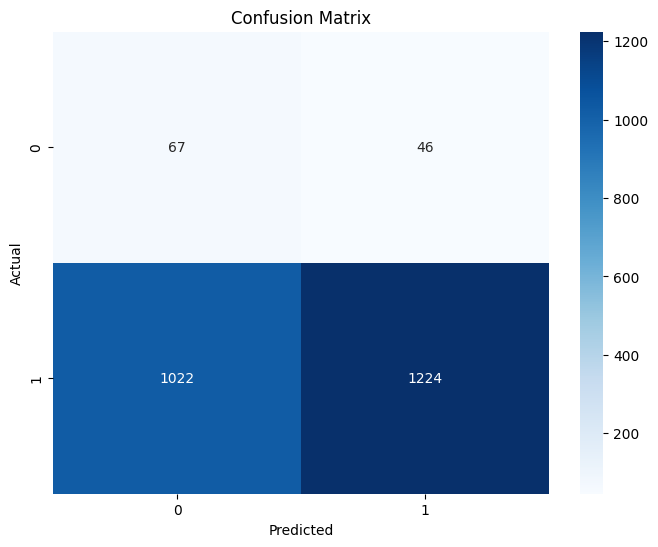

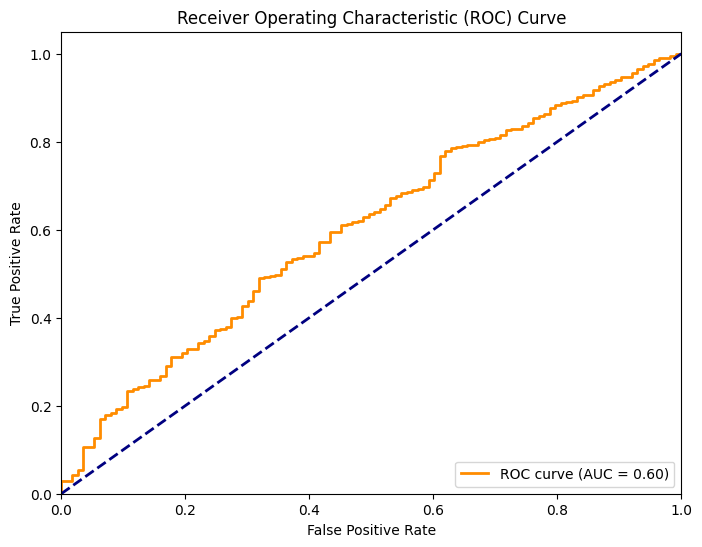

In [49]:
# Word2vec Dense Vectors
X_word2vec = np.load('/content/word2vec_vectors.npy')
if len(X_word2vec) > len(y):
    X_word2vec = X_word2vec[:len(y)]
model_glove = train_and_evaluate(X_word2vec, y)